Let's import useful packages.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-whitegrid')

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [4]:
from tqdm import tqdm

In [5]:
import numpy as np
import pandas as pd

Data preparation.

In [6]:
X, y = make_classification(n_samples=5000,
                           n_features=5,
                           n_redundant=2,
                           n_classes=2,
                           weights=[0.7],
                           class_sep=0.7,
                           random_state=15)
print(X.shape, y.shape)

(5000, 5) (5000,)


Data splitting.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(3200, 5) (3200,)
(800, 5) (800,)
(1000, 5) (1000,)


`SVC` model.

In [8]:
clf = SVC(gamma=0.001, C=100.)
clf.fit(X=X_train, y=y_train)

SVC(C=100.0, gamma=0.001)

In [9]:
y_alpha = clf.dual_coef_[0]
print(y_alpha.shape)

(585,)


In [10]:
sup_vecs = clf.support_vectors_
print(sup_vecs.shape)

(585, 5)


In [11]:
intercept = clf.intercept_[0]
print(intercept)

0.9307897393282303


Kernel trick.

Norm: https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

In [12]:
def compute_kernel_trick(xq, vector, gamma):
    """
    This function computes the kernel trick.
    """
    k = np.exp(-gamma * np.linalg.norm(x=(xq-vector)) ** 2)
    return k

Decision function.

In [13]:
def decision_function(Xq, y_alpha, sup_vecs, intercept, gamma):
    """
    This method computes the decision function.
    """
    total = sup_vecs.shape[0]
    deci_vals = list()
    for xq in Xq:
        vals = np.sum([y_alpha[i] * 
                       compute_kernel_trick(xq=xq,
                                            vector=sup_vecs[i],
                                            gamma=gamma) 
                       for i in range(total)])
        d_sum = vals + intercept
        deci_vals.append(d_sum)
    deci_vals = np.array(deci_vals)
    return deci_vals

In [14]:
actual_cv = clf.decision_function(X=X_cv)

In [15]:
f_cv = decision_function(Xq=X_cv, y_alpha=y_alpha, sup_vecs=sup_vecs, intercept=intercept, gamma=0.001)

In [16]:
print(actual_cv.shape == f_cv.shape)

True


In [17]:
print(actual_cv[:20])
print(f_cv[:20])

[ 0.11678463  2.10419471  0.79927688 -3.15387783 -1.54749615 -3.34018573
  1.39803127 -0.20547436 -1.81747348 -3.36782139 -2.39057524  2.45882518
 -2.51024249  2.4216617  -2.1334898   2.09460278 -1.62149912 -3.12519872
 -3.37911696  1.47961468]
[ 0.11678463  2.10419471  0.79927688 -3.15387783 -1.54749615 -3.34018573
  1.39803127 -0.20547436 -1.81747348 -3.36782139 -2.39057524  2.45882518
 -2.51024249  2.4216617  -2.1334898   2.09460278 -1.62149912 -3.12519872
 -3.37911696  1.47961468]


In [18]:
print(np.allclose(a=actual_cv, b=f_cv))

True


---

Data calibration.

In [19]:
class DataCalibration(object):
    """
    Implements the data calibration.
    """
    
    def __init__(self, f_cv, y_cv, chunks=50):
        self.f_cv = f_cv
        self.y_cv = y_cv
        self.chunks = chunks
        self.calib_table = self.construct_calibration_table()
        self.avg_df = self.make_chunks()
        self.x = self.avg_df.values[:, 0]
        self.y = self.avg_df.values[:, 1]
        self.p = self.prediction()
    
    def construct_calibration_table(self):
        """
        This method constructs the calibration table.
        """
        df = pd.DataFrame()
        df['y_cap'] = self.f_cv
        df['y_act'] = self.y_cv
        df = df.sort_values(by=['y_cap'])
        return df
    
    def make_chunks(self):
        """
        This method divides the data into chucks.
        """
        avgs = list()
        all_chunks = np.array_split(ary=self.calib_table, indices_or_sections=self.chunks)
        for each_chunk_df in all_chunks:
            avg_val = each_chunk_df.mean().values
            avgs.append(avg_val)
        avg_matrix = np.matrix(avgs)
        cols = list(self.calib_table.columns)
        avg_df = pd.DataFrame(data=avg_matrix, columns=cols)
        return avg_df
    
    def prediction(self):
        """
        This method computes the polyfit of `y_cap` and `y_act` from average dataframe.
        """
        w, b = np.polyfit(x=self.x, y=self.y, deg=1)
        p = (w * self.x) + b
        return p
    
    def plot_calibration(self):
        """
        This method plots the calibration plot.
        """
        plt.figure(figsize=(10, 6))
        plt.title(label='Calibration Plot')
        plt.plot(self.x, self.y, 'o--', color='b', label='$(\hat{y}, y)$')
        plt.plot(self.x, self.p, '--', color='g', label='Predicition')
        plt.xlabel(xlabel='Average $\hat{y}$')
        plt.ylabel(ylabel='Average $y$')
        plt.legend()
        plt.show()

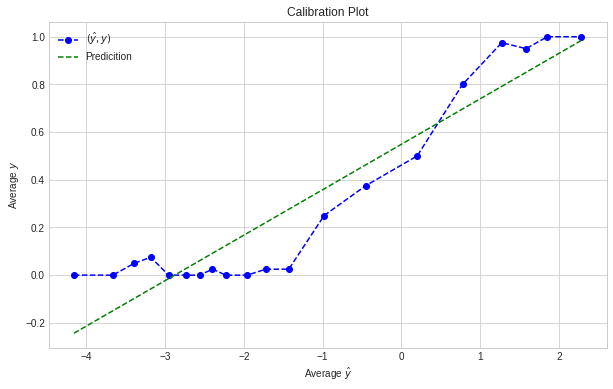

In [20]:
dc = DataCalibration(f_cv=f_cv, y_cv=y_cv, chunks=20)
dc.plot_calibration()

Modify the targets for Platt Scaling.

In [21]:
def modify_targets(y_train, ys):
    """
    This function modifies the targets for Platt Scaling.
    """
    N_plus = np.count_nonzero(a=y_train)
    N_minus = len(y_train) - N_plus
    y_plus = (N_plus + 1) / (N_plus + 2)
    y_minus = 1 / (N_minus + 2)
    ys_m = np.where((ys == 1), y_plus, y_minus)
    return ys_m

In [22]:
y_cv_m = modify_targets(y_train=y_train, ys=y_cv)
print(y_cv_m[:10])

[9.98970134e-01 9.98970134e-01 9.98970134e-01 4.47828034e-04
 4.47828034e-04 4.47828034e-04 9.98970134e-01 9.98970134e-01
 4.47828034e-04 4.47828034e-04]


In [23]:
y_test_m = modify_targets(y_train=y_train, ys=y_test)
print(y_test_m[:10])

[4.47828034e-04 4.47828034e-04 4.47828034e-04 9.98970134e-01
 4.47828034e-04 4.47828034e-04 4.47828034e-04 9.98970134e-01
 4.47828034e-04 4.47828034e-04]


In [24]:
f_test = decision_function(Xq=X_test, y_alpha=y_alpha, sup_vecs=sup_vecs, intercept=intercept, gamma=0.001)

In [25]:
f_cv_m = f_cv.reshape(-1, 1)
f_test_m = f_test.reshape(-1, 1)

SGD Classifier.

In [26]:
class CustomSGDClassifier(object):
    """
    This class executes the Custom SGD Classifier.
    """
    
    def __init__(self, f_cv, y_cv, f_test, y_test, alpha, eta0, epochs):
        self.f_cv = f_cv
        self.y_cv = y_cv
        self.f_test = f_test
        self.y_test = y_test
        self.alpha = alpha
        self.eta0 = eta0
        self.epochs = epochs
        self.N = len(self.f_cv)
    
    def initialize_weights(self, dim):
        """
        This method initializes weights.
        """
        w = np.zeros_like(a=dim)
        b = 0
        return w, b
    
    def sigmoid(self, z):
        """
        This method computes sigmoid function of z.
        """
        sigval = 1 / (1 + np.exp(-z))
        return sigval
    
    def logloss(self, y_true, y_pred):
        """
        This method computes the log loss.
        """
        l = 0
        n = len(y_true)
        for y_t, y_p in zip(y_true, y_pred):
            l += (y_t * np.log10(y_p)) + ((1 - y_t) * np.log10(1 - y_p))
        loss = (-1 / n) * l
        return loss
    
    def gradient_dw(self, x, y, w, b):
        """
        This method computes the gradient w.r.t `w`.
        """
        z = np.dot(a=w.T, b=x) + b
        dw = x * (y - self.sigmoid(z=z)) - ((self.alpha / self.N) * w)
        return dw
    
    def gradient_db(self, x, y, w, b):
        """
        This method computes the gradient w.r.t `b`.
        """
        z = np.dot(a=w.T, b=x) + b
        db = y - self.sigmoid(z=z)
        return db
    
    def predict(self, w, b, X):
        """
        This method predicts.
        """
        N = len(X)
        pred = list()
        for i in range(N):
            z = np.dot(w, X[i]) + b
            pred.append(self.sigmoid(z=z))
        return np.array(pred)
    
    def train(self):
        """
        This method fits the data.
        """
        cv_loss = list()
        test_loss = list()
        e_list = list()
        w, b = self.initialize_weights(dim=self.f_cv[0])
        for e in tqdm(range(self.epochs)):
            for xi, yi in zip(self.f_cv, self.y_cv):
                dw = self.gradient_dw(x=xi, y=yi, w=w, b=b)
                db = self.gradient_db(x=xi, y=yi, w=w, b=b)
                w = w + self.eta0 * dw
                b = b + self.eta0 * db
            cv_pred = self.predict(w=w, b=b, X=self.f_cv)
            cv_l = self.logloss(y_true=self.y_cv, y_pred=cv_pred)
            cv_loss.append(cv_l)
            test_pred = self.predict(w=w, b=b, X=self.f_test)
            test_l = self.logloss(y_true=self.y_test, y_pred=test_pred)
            test_loss.append(test_l)
            e_list.append(e)
        print("\nWeight: {}".format(w[0]))
        print("Bias: {}".format(b))
        plt.figure(figsize=(10, 6))
        plt.plot(e_list, cv_loss, color='r', label='CV Loss')
        plt.plot(e_list, test_loss, color='b', label='Test Loss')
        plt.xlabel(xlabel='Epochs')
        plt.ylabel(ylabel='Loss')
        plt.title(label='Epochs Vs Loss')
        plt.legend()
        plt.show()
        return w[0], b

In [27]:
clf_sgd = CustomSGDClassifier(f_cv=f_cv_m,
                              y_cv=y_cv_m,
                              f_test=f_test_m,
                              y_test=y_test_m, 
                              alpha=0.0001,
                              eta0=0.0001,
                              epochs=1000)

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.04it/s]



Weight: 1.7584310796229727
Bias: 0.16394466838611874


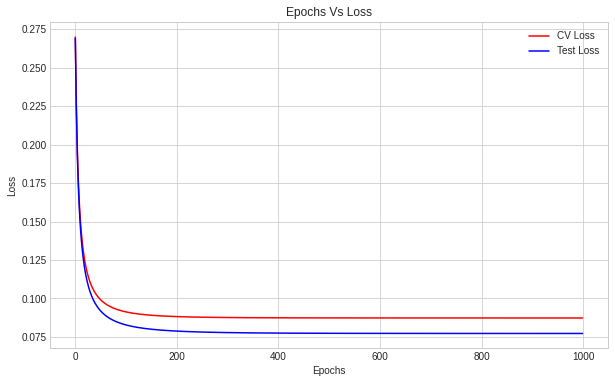

In [28]:
w, b = clf_sgd.train()

$P(y=1|X_{test})$

In [29]:
prob_given_X_test = (1 / (1 + np.exp(-((w * f_test_m) + b)))).reshape(1, -1)[0]
print(prob_given_X_test[:10])
print(len(prob_given_X_test) == X_test.shape[0])

[2.38405602e-02 3.20720577e-02 5.49068383e-04 6.02580902e-01
 1.81939437e-02 3.47579781e-02 3.21813463e-03 1.19767630e-01
 3.84434322e-03 2.81554937e-03]
True


---

End of the file.